<a href="https://colab.research.google.com/github/PaudelSiddhanta/Rectangular_EIT/blob/main/rectangular_NN_using_gpun10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch
import torch.nn as nn
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import copy

In [13]:
#Check GPU availability (add at the start of the notebook)
import torch
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure a GPU is available for this run.")
print(f"Running on GPU: {torch.cuda.get_device_name(0)}")


Running on GPU: Tesla T4


In [14]:
#  SquareEITNN class with explicit CUDA
class SquareEITNN(nn.Module):
    def __init__(self, grid):
        super(SquareEITNN, self).__init__()
        self.grid = grid
        self.n = grid.n
        self.input_size = 8 * self.n
        self.hidden_size = self.n ** 2 + 8 * self.n
        self.output_size = self.n ** 2 + 4 * self.n
        self.interior_size = self.n ** 2
        self.neumann_copy_start = self.n ** 2 + 4 * self.n
        self.device = torch.device("cuda")

        # Initialize W1 as a single Parameter matrix
        self.W1 = nn.Parameter(torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False)).to(self.device)
        self.W1_fixed = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64).to(self.device)
        self.W1_fixed_mask = torch.ones(self.hidden_size, self.input_size, dtype=torch.bool).to(self.device)
        self.W1_fixed_mask[:self.interior_size, :4*self.n] = False  # Make top left n^2 by 4n matrix trainable

        self.W1__grad = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False).to(self.device)
        self.W2__grad = torch.zeros(self.output_size, self.hidden_size, dtype=torch.float64, requires_grad=False).to(self.device)
        self._initialize_W1_blocks()
        self._initialize_W2()


    def assign_gradients(self, x_data, h, y, alpha):
        """
        Compute gradients for W1 and W2 (Beta) manually for comparison.

        Args:
            x_data (torch.Tensor): Input data of shape (batch_size, 8n).
            h (torch.Tensor): Hidden layer output of shape (batch_size, n^2 + 8n).
            y (torch.Tensor): Output of shape (batch_size, n^2 + 4n).
            alpha (float): Regularization parameter for the loss function.
        """
        with torch.no_grad():
            batch_size = y.shape[0]
            dL_dy = torch.zeros_like(y).to(self.device)  # shape: (batch_size, n^2 + 4n)
            dL_dy[:, :self.n**2] = alpha * y[:, :self.n**2] / batch_size
            dL_dy[:, self.n**2:] = y[:, self.n**2:] / batch_size

            # Gradient w.r.t. W2_dynamic
            dW2 = dL_dy.T @ h  # shape: (n^2 + 4n, n^2 + 8n)
            grad = {}
            w2_indices = [(i, j) for i in range(self.n**2) for j in self.grid.get_node_by_index(i).neighbors if i < j < self.interior_size + 4*self.n]
            for i, j in w2_indices:
                grad[(i, j)] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]
                self.W2__grad[i, j] = grad[(i, j)] / (1 + self.Beta[i, j]**2)

            # Gradient w.r.t. W1 (trainable part: top-left n^2 x 4n)
            dW1 = self.W2_dynamic.T @ dL_dy.T @ x_data  # shape: (n^2 + 8n, 8n)
            for i in range(self.n**2):
                for j in range(4*self.n):
                    self.W1__grad[i, j] = dW1[i, j]

    def _initialize_W1_blocks(self):
        with torch.no_grad():
            self.W1[:self.interior_size, :4*self.n] = torch.randn(self.interior_size, 4*self.n, dtype=torch.float64).to(self.device)
            self.W1[:self.interior_size, 4*self.n:] = 0.0
            self.W1_fixed[:self.interior_size, 4*self.n:] = 0.0
            self.W1[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1_fixed[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)


    def _initialize_W2(self):
        size_out = self.output_size
        size_hidden = self.hidden_size
        self.Beta = nn.Parameter(torch.zeros(size_out, size_hidden, dtype=torch.float64, requires_grad=False)).to(self.device)
        self.W2_fixed = torch.zeros(size_out, size_hidden, dtype=torch.float64).to(self.device)
        self.W2_mask = torch.ones(size_out, size_hidden, dtype=torch.bool).to(self.device)

        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                weights = torch.abs(torch.randn(len(neighbor_indices), dtype=torch.float64)).to(self.device)
                for k, j in enumerate(neighbor_indices):
                    self.Beta[i,j] = weights[k]
                    self.Beta[j, i] = weights[k]
                    self.W2_fixed[j, i] = weights[k]
                    self.W2_mask[i, j] = False
                self.Beta[i, i] = 0
                self.W2_fixed[i, i] = 0

            for i in range(self.interior_size + 4*self.n):
                self.Beta[i, i] = -torch.sum(torch.tensor([self.Beta[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))

            for i in range(4*self.n):
                row = self.interior_size + i
                col = self.neumann_copy_start + i
                self.Beta[row, col] = 1.0
                self.W2_fixed[row, col] = 1.0

    def symmetrize_W2_after_training(self):
        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                for k, j in enumerate(neighbor_indices):
                    self.W2_fixed[i,j] = self.transform(self.Beta[i,j])
                    self.W2_fixed[j,i] = self.transform(self.Beta[i,j])
            for i in range(self.interior_size + 4*self.n):
                self.W2_fixed[i, i] = 0
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))

    def transform(self, x):
        return torch.arctan(x) + torch.pi/2

    def forward(self, x):
        self.W1_dynamic = torch.where(self.W1_fixed_mask, self.W1_fixed, self.W1).to(self.device)
        self.W2_dynamic = torch.where(self.W2_mask, self.W2_fixed, torch.arctan(self.Beta) + torch.pi/2).to(self.device)
        hid = torch.matmul(x, self.W1_dynamic.t())
        outp = torch.matmul(hid, self.W2_dynamic.t())
        return outp, hid







In [15]:
#  generate_dtn_data with explicit CUDA
def generate_dtn_data(grid, batch_size):
    device = torch.device("cuda")
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)

    for k in range(min(batch_size, 4*grid.n)):
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)
    return data

In [16]:

# loss_function with explicit CUDA
def loss_function(output, grid, alpha=1.0):
    device = torch.device("cuda")
    batch_size = output.size(0)
    interior = output[:, :-4*grid.n].to(device)
    boundary = output[:, -4*grid.n:].to(device)
    lss = (alpha * torch.sum(interior ** 2) + torch.sum(boundary ** 2)) / (2 * batch_size)
    return lss

In [17]:
# Cell 5: adam with explicit CUDA
def adam(param, grad, alpha, m_t, v_t, beta1, beta2, eps, time_step):
    device = torch.device("cuda")
    with torch.no_grad():
        if grad is None:
            grad = torch.zeros_like(param).to(device)
        m_t1 = beta1 * m_t + (1 - beta1) * grad
        v_t1 = beta2 * v_t + (1 - beta2) * (grad ** 2)
        m_corr = m_t1 / (1 - beta1 ** time_step)
        v_corr = v_t1 / (1 - beta2 ** time_step)
        param = param - alpha * m_corr / (torch.sqrt(v_corr) + eps)
        return param, m_t1, v_t1

In [18]:
# train_model_adam with explicit CUDA
def train_model_adam(num_epoch, dataloader, model, alpha, learning_rate, grid,
                     beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4, update_step=4000):
    device = torch.device("cuda")
    model.to(device)  # Move model to GPU
    num_epochs = num_epoch
    loss_record = []

    # Initialize Adam states
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})

    t = 1
    best_loss = float('inf')
    delta_thresh = init_delta_thresh
    epochs_since_improvement = 0
    min_lr = 1e-8
    max_beta1 = 0.9995
    max_beta2 = 0.9999
    for epoch in range(num_epochs):
        for batch_x in dataloader:
            batch_x = batch_x.to(device)  # Move input data to GPU
            model.zero_grad()
            output, hid = model(batch_x)
            loss = loss_function(output, grid, alpha)
            model.assign_gradients(batch_x, hid, output, alpha)
            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam(param, grad, learning_rate, m, v, beta1, beta2, eps, t)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1
            model.symmetrize_W2_after_training()

            if (epoch + 1) % update_step == 0:
                learning_rate = max(learning_rate * 0.01, min_lr)

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6e}')

    # Final processing
    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()  # Move to CPU for numpy conversion
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]
    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    return loss_record, estimated_conductivities

In [19]:
n = 10
batch_size = 4*n
grid = GridStructure(n)
data = generate_dtn_data(grid, batch_size)  # Uses grid3
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
model = SquareEITNN(grid)
alpha = 1
num_epoch = 30000
learning_rate = 0.02
update_step3 = 4000

Epoch [1000/30000], Loss: 1.567856e-01
Epoch [2000/30000], Loss: 3.237193e-03
Epoch [3000/30000], Loss: 2.320623e-03
Epoch [4000/30000], Loss: 2.931163e-03
Epoch [5000/30000], Loss: 2.376037e-04
Epoch [6000/30000], Loss: 1.363813e-04
Epoch [7000/30000], Loss: 8.027471e-05
Epoch [8000/30000], Loss: 4.874852e-05
Epoch [9000/30000], Loss: 4.821106e-05
Epoch [10000/30000], Loss: 4.794992e-05
Epoch [11000/30000], Loss: 4.769159e-05
Epoch [12000/30000], Loss: 4.743561e-05
Epoch [13000/30000], Loss: 4.743278e-05
Epoch [14000/30000], Loss: 4.743023e-05
Epoch [15000/30000], Loss: 4.742768e-05
Epoch [16000/30000], Loss: 4.742513e-05
Epoch [17000/30000], Loss: 4.742385e-05
Epoch [18000/30000], Loss: 4.742258e-05
Epoch [19000/30000], Loss: 4.742130e-05
Epoch [20000/30000], Loss: 4.742003e-05
Epoch [21000/30000], Loss: 4.741875e-05
Epoch [22000/30000], Loss: 4.741748e-05
Epoch [23000/30000], Loss: 4.741621e-05
Epoch [24000/30000], Loss: 4.741493e-05
Epoch [25000/30000], Loss: 4.741366e-05
Epoch [26

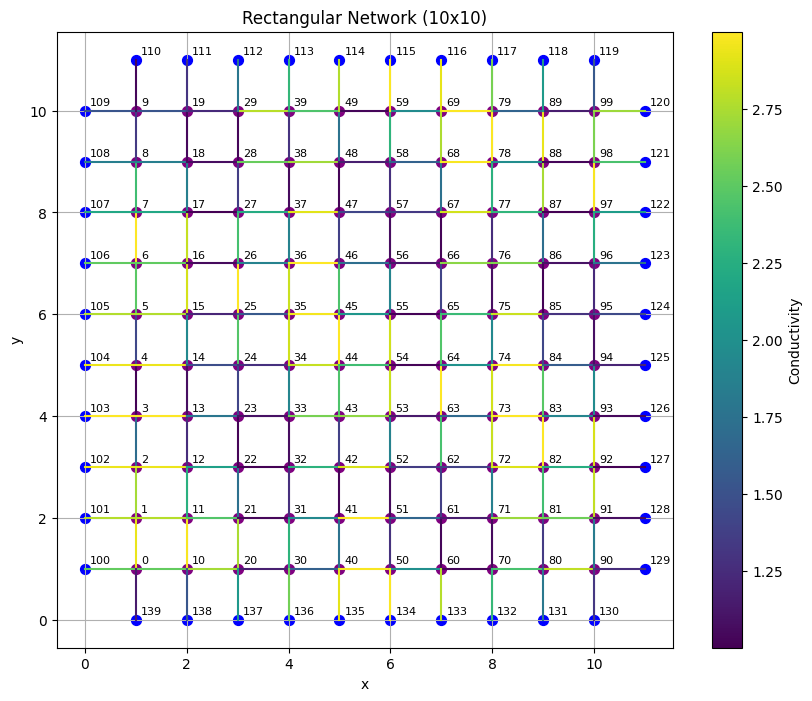

Recovered Conductivity


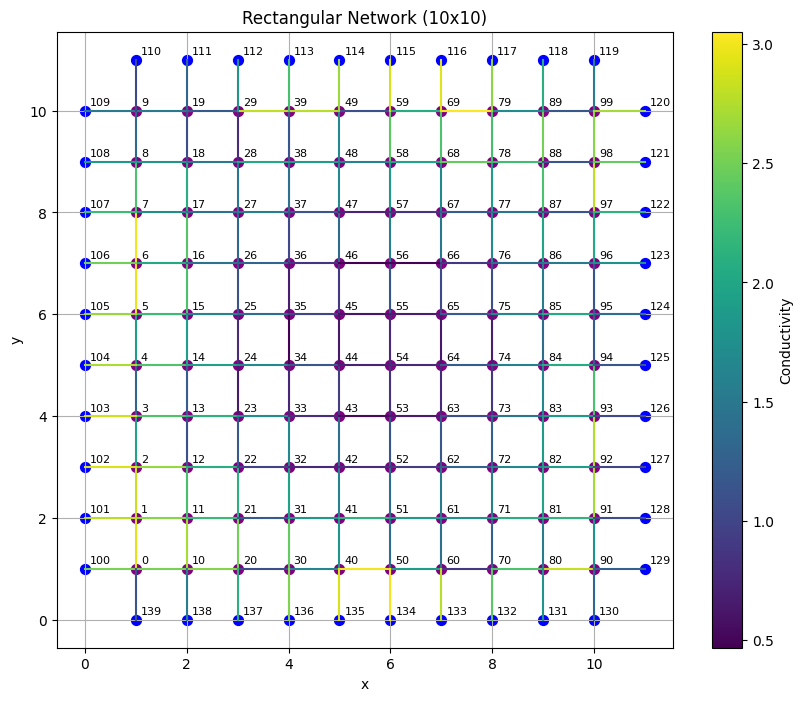

([],
 {(0, 1): np.float64(2.930630804557987),
  (0, 10): np.float64(2.518525147555513),
  (0, 100): np.float64(2.5227086702897905),
  (0, 139): np.float64(1.1451847862672637),
  (1, 2): np.float64(2.8336226652075185),
  (1, 11): np.float64(2.5913811552925763),
  (1, 101): np.float64(2.787570759771884),
  (2, 3): np.float64(1.9711715138524637),
  (2, 12): np.float64(2.6400808726481793),
  (2, 102): np.float64(2.903746717336707),
  (3, 4): np.float64(1.3029970157641384),
  (3, 13): np.float64(2.3330617212046256),
  (3, 103): np.float64(2.8541295941126545),
  (4, 5): np.float64(1.8945162583559565),
  (4, 14): np.float64(2.330733181580384),
  (4, 104): np.float64(2.726590002660589),
  (5, 6): np.float64(2.9615020293438197),
  (5, 15): np.float64(2.2299057338103467),
  (5, 105): np.float64(2.6545370897292067),
  (6, 7): np.float64(2.998342299710364),
  (6, 16): np.float64(2.0416733315001734),
  (6, 106): np.float64(2.491755460592744),
  (7, 8): np.float64(2.319011408149149),
  (7, 17): np.f

In [20]:
train_model_adam(num_epoch, dataloader, model, alpha, learning_rate, grid,
                     beta1=0.9, beta2=0.99, eps=1e-8, patience=500, init_delta_thresh=1e-4, update_step=4000)